<h1 style="font-size:30px">Patient Treatment Classification</h1>

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# for Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

import pickle

# To ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

# for styling
plt.style.use('seaborn-whitegrid')

# 5. Load and split data

In [2]:
data = pd.read_csv('archive/data-ori.csv')
data.head(3)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out


Let's divide the data into train and test sets.<br>
Train : 80% of data<br>
Test : 20% of data

In [3]:

data['SOURCE'] = data.SOURCE.replace({"in":1, 'out':0})

features = [feat for feat in data.columns if feat !='SOURCE']

X = data[features] # feature set
y = data['SOURCE'] # target

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# train and test datasets dimensions
X_train.shape, X_test.shape

((3529, 10), (883, 10))

# 6. Exploratory data analysis

### Dataset Overview

In [6]:
print(f"The dataset contains {data.shape[0]} rows and {data.shape[1]} columns")

num_features = [feat for feat in features if data[feat].dtype != object]
cat_features = [feat for feat in features if data[feat].dtype == object]

print(f"Total number of features : {len(features)}")
print(f"Number of numerical features : {len(num_features)}")
print(f"Number of categorical features : {len(cat_features)}\n")

The dataset contains 4412 rows and 11 columns
Total number of features : 10
Number of numerical features : 9
Number of categorical features : 1



### Missing values

In [26]:
# Show the percentage of missing values in each feature

data.isna().mean().to_frame(name='Missing %')

,Missing %
HAEMATOCRIT,0.0
HAEMOGLOBINS,0.0
ERYTHROCYTE,0.0
LEUCOCYTE,0.0
THROMBOCYTE,0.0
MCH,0.0
MCHC,0.0
MCV,0.0
AGE,0.0
SEX,0.0


Observation : Luckily, we didn't find any missing values.

### Unique values

In [27]:
# To count number unique values in each feature

data.nunique().to_frame(name='# of unique values')

,# of unique values
HAEMATOCRIT,326
HAEMOGLOBINS,128
ERYTHROCYTE,433
LEUCOCYTE,276
THROMBOCYTE,554
MCH,189
MCHC,105
MCV,406
AGE,95
SEX,2


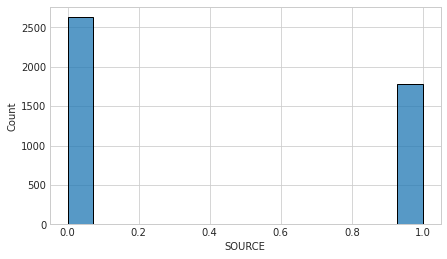

In [28]:
# Target distribution

plt.figure(figsize=(7,4))
fig = sns.histplot(x='SOURCE', data=data)

In [29]:


data.SOURCE.value_counts().to_frame(name='Count')

,Count
0,2628
1,1784


In [30]:
data[num_features].describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000
mean,38.197688,12.741727,4.541260,8.718608,257.524479,28.234701,33.343042,84.612942,46.626473
std,5.974784,2.079903,0.784091,5.049041,113.972365,2.672639,1.228664,6.859101,21.731218
min,13.700000,3.800000,1.480000,1.100000,8.000000,14.900000,26.000000,54.000000,1.000000
25%,34.375000,11.400000,4.040000,5.675000,188.000000,27.200000,32.700000,81.500000,29.000000
50%,38.600000,12.900000,4.570000,7.600000,256.000000,28.700000,33.400000,85.400000,47.000000
75%,42.500000,14.200000,5.050000,10.300000,321.000000,29.800000,34.100000,88.700000,64.000000
max,69.000000,18.900000,7.860000,76.600000,1183.000000,40.800000,39.000000,115.600000,99.000000


#### Box plot

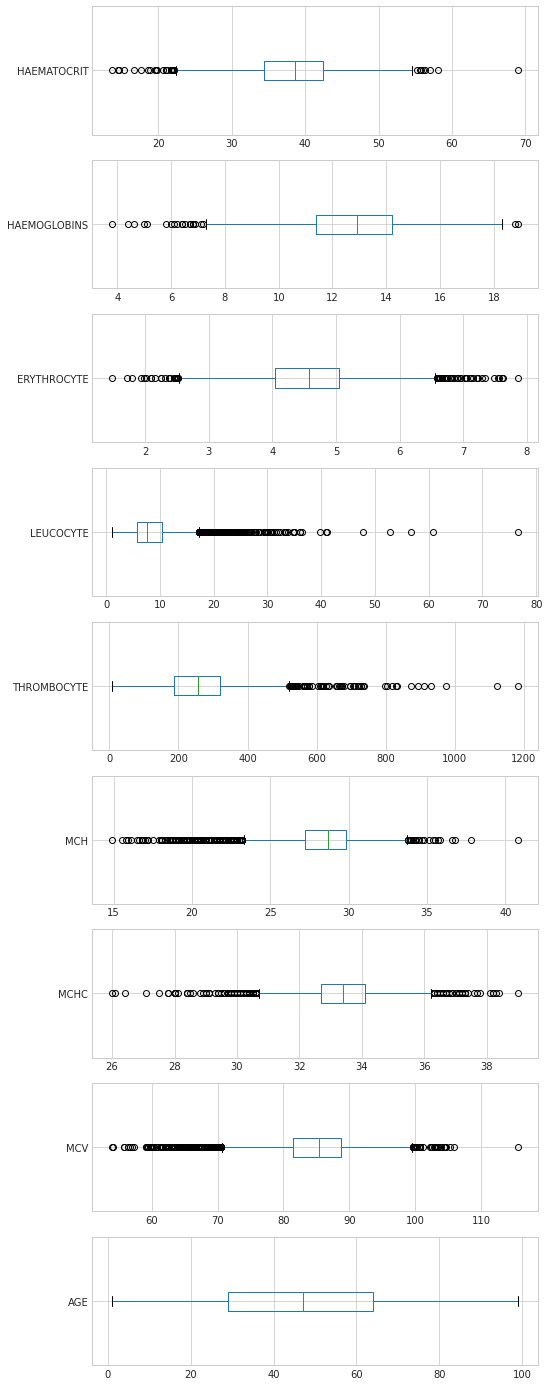

In [31]:


fig, axes = plt.subplots(9, 1, figsize=(8, 25))
for i, c in enumerate(num_features):
    f = data[[c]].boxplot(ax=axes[i], vert=False)

##### Density plot

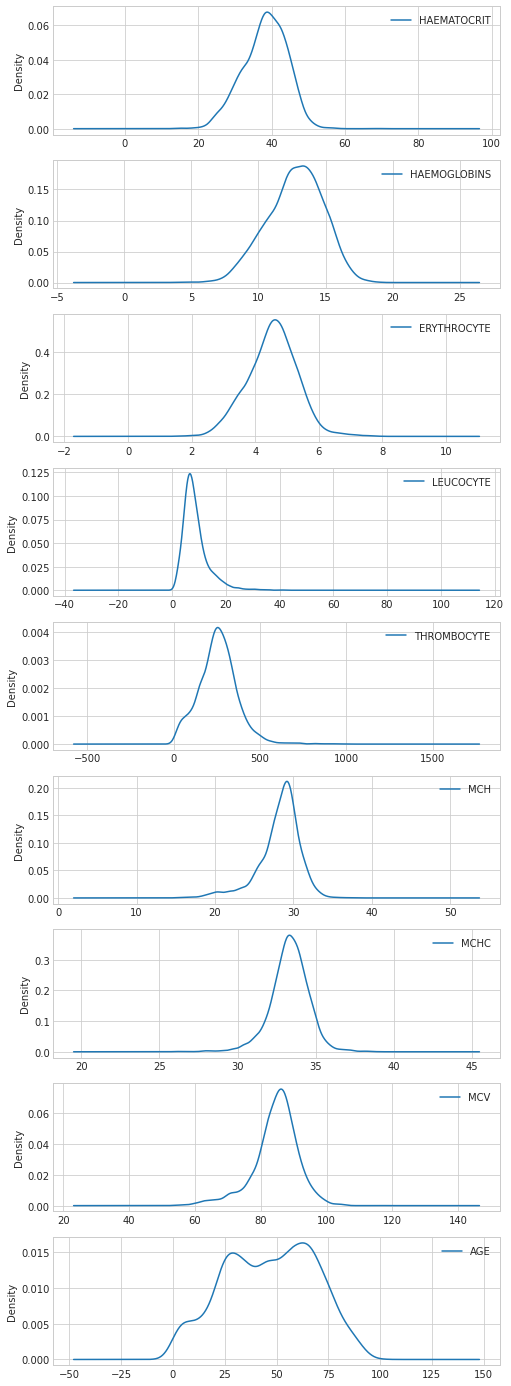

In [32]:


fig, axes = plt.subplots(9, 1, figsize=(8, 25))
for i, c in enumerate(num_features):
    f = data[[c]].plot(kind='kde',ax=axes[i])

Observations:
- Few outliers are present in some numerical features
- Most of the features follows the Gaussian distribution (approx.)

### 6.1.3 Categorical feature(s)
name : SEX<br>
labels : F, M

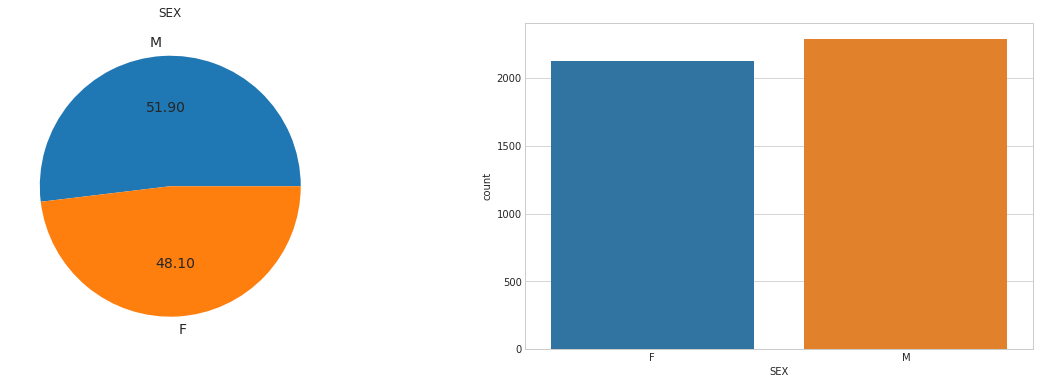

In [33]:

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
df = data['SEX'].value_counts()
barplot = df.plot(kind='pie', ax=axes[0], title='SEX', autopct="%.2f", fontsize=14, ylabel='')
countplot = sns.countplot(x='SEX', data=data, ax=axes[1])

## 6.2 Bivariate analysis

### 6.2.1 Numerical features

#### KDE plot

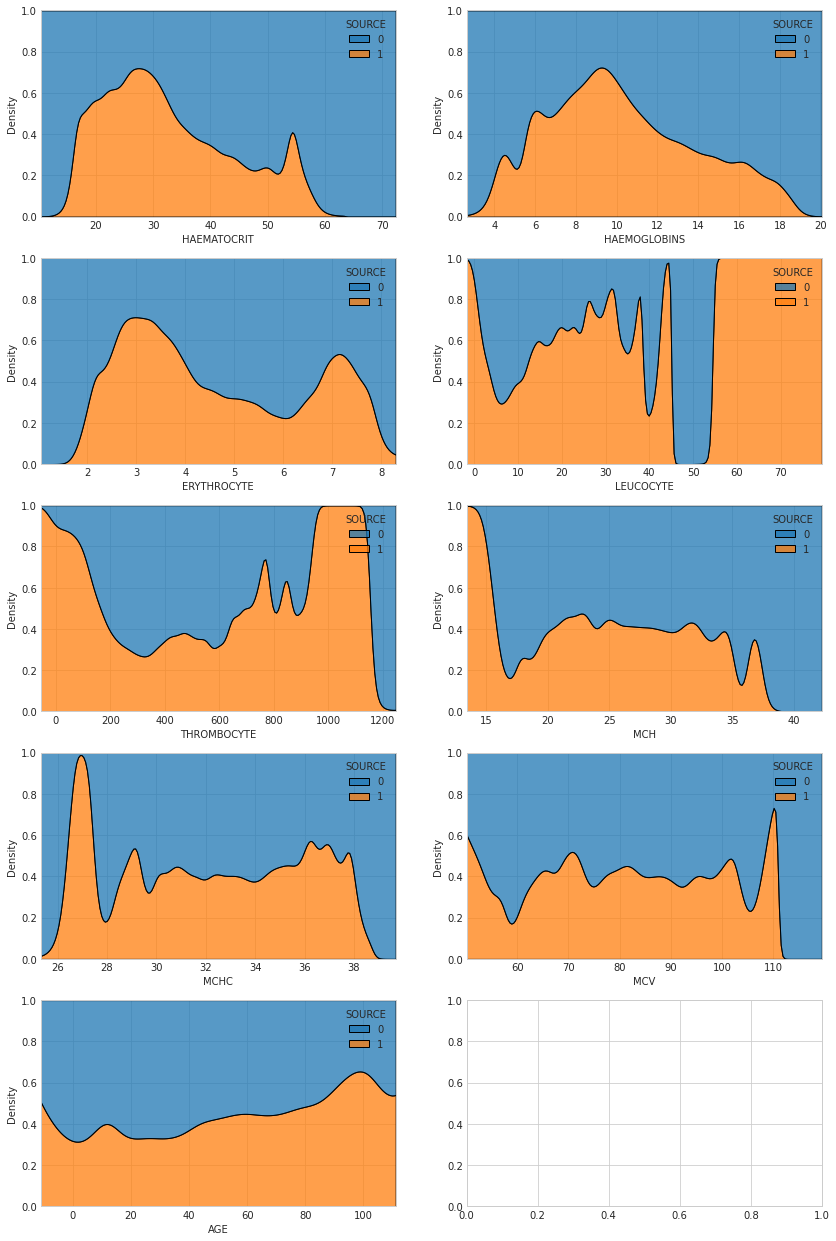

In [34]:


fig, axes = plt.subplots(5,2, figsize=(14,22))
axes = [ax for axes_row in axes for ax in axes_row]
for i,c in enumerate(data[num_features]):
    plot = sns.kdeplot(data=data, x=c, hue='SOURCE', multiple='fill', ax=axes[i])

#### Bar plot

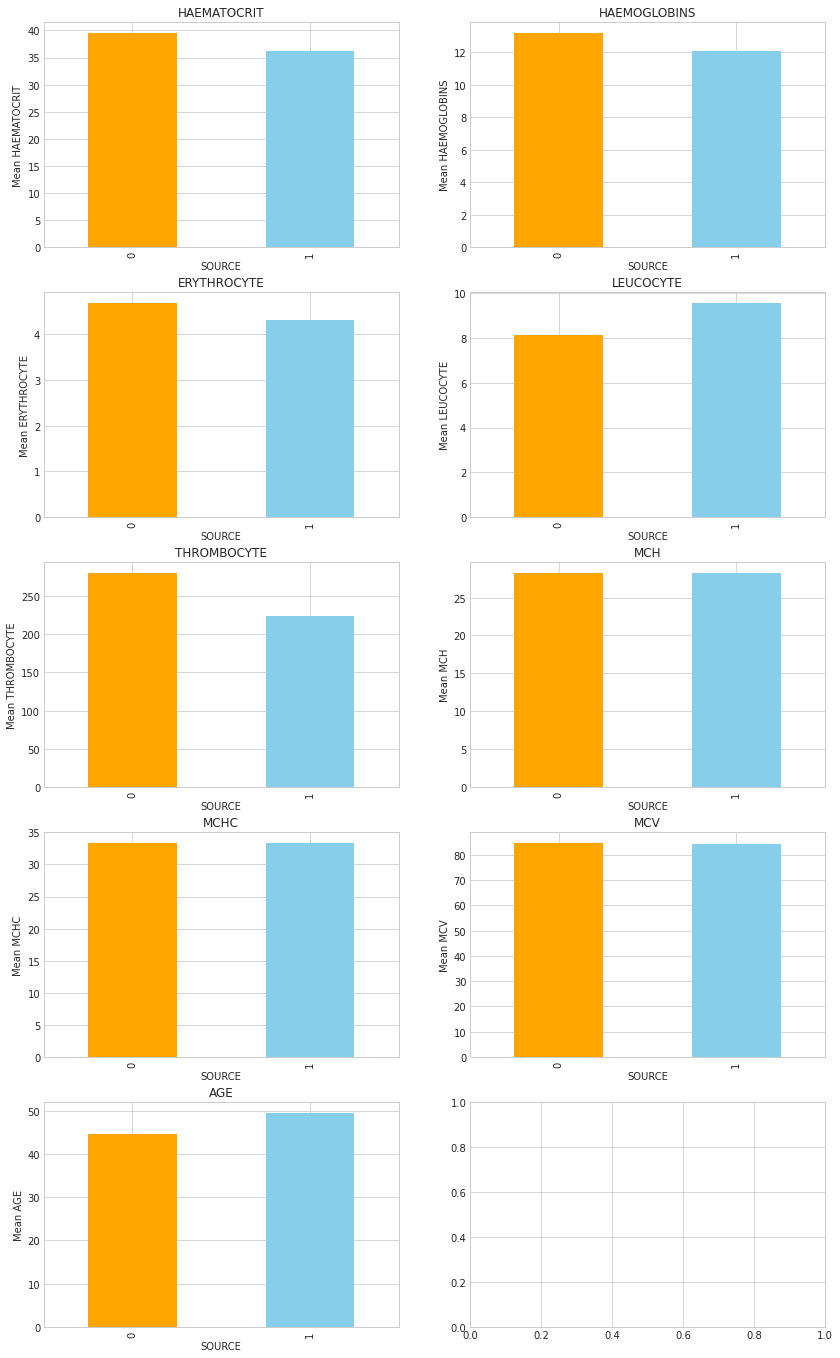

In [35]:


fig, axes = plt.subplots(5,2, figsize=(14,24))
axes = [ax for axes_row in axes for ax in axes_row]
for i,c in enumerate(data[num_features]):
    df = data.groupby("SOURCE")[c].mean()
    plot = df.plot(kind='bar', title=c, ax=axes[i], ylabel=f'Mean {c}', color=('orange','skyblue'))

Observations:
- On average, The quantity of HAEMOTOCRIT, HAEMOGLOBINS, ERYTHROCYTE, and THROMBOCYTE features are lesser in In care patients.
- MCH, MCHV, MCV are less informative to differentiate classes
- The mean age of Incare patients is greater than the Outcare patients.

#### Correlation - matrix

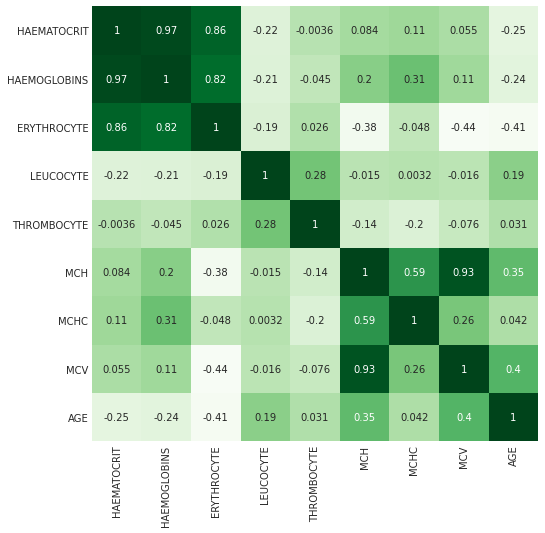

In [36]:


corr_matt = data[num_features].corr(method='pearson')
plt.figure(figsize=(8,8))
corr = sns.heatmap(corr_matt, annot=True, cmap='Greens', cbar=False)

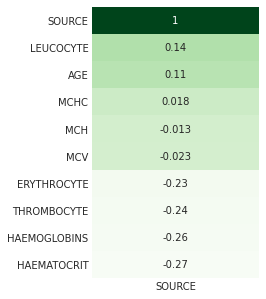

In [37]:


corr_matt = data.corr(method='pearson')[['SOURCE']].sort_values(by='SOURCE',ascending=False)
plt.figure(figsize=(3,5))
corr = sns.heatmap(corr_matt, annot=True, cmap='Greens', cbar=False)

Observations:
- LEUCOCYTE and AGE are postively correlated with target
- THROMBOCYTE, ERYTHROCYTE, HAEMOGLOBINS and HAEMATOCRIT are negatively correlated with target
- No notable correlation found between MCHC, MCH, MCV, and target

### 6.2.2 Categorical feature(s)

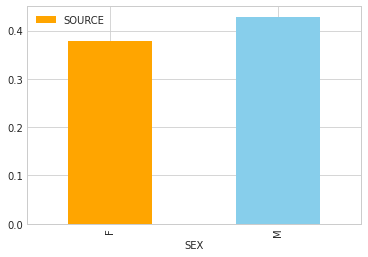

In [38]:


df = data.groupby('SEX')['SOURCE'].mean().to_frame().reset_index()
plot = df.plot(kind='bar', x='SEX', y='SOURCE', color=('orange', 'skyblue'))

Observation:
- Male Incare patients are more in number than Female Incare patients

# 7. Feature Engineering

### Label encoding

In [7]:




X_train.SEX.replace({'F':0, 'M':1}, inplace=True)
X_test.SEX.replace({'F':0, 'M':1}, inplace=True)

### Feature Scaling

Transform all the numerical features into a range [0, 1]

In [8]:




scaler = MinMaxScaler(feature_range=(0, 1))

X_train[num_features] = scaler.fit_transform(X_train[num_features]) #fit and transform the train set
X_test[num_features] = scaler.transform(X_test[num_features]) #transform the test test

In [9]:


X_train.head(3)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX
2902,0.594595,0.675497,0.504702,0.052980,0.139574,0.575290,0.684615,0.508117,0.591837,1
1282,0.373874,0.403974,0.330721,0.213245,0.233191,0.490347,0.515385,0.493506,0.316327,0
2571,0.295045,0.337748,0.329154,0.075497,0.001702,0.386100,0.553846,0.339286,0.540816,0


# 8. Feature selection
In exploratory data analysis, we found out that the features MCH, MCHC and MCV are not very useful in predicting the target. Let's remove those features.

In [10]:


X_train.drop(['MCH', 'MCHC','MCV'], axis=1, inplace=True)
X_test.drop(['MCH', 'MCHC','MCV'], axis=1, inplace=True)


X_train.head(3)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,AGE,SEX
2902,0.594595,0.675497,0.504702,0.052980,0.139574,0.591837,1
1282,0.373874,0.403974,0.330721,0.213245,0.233191,0.316327,0
2571,0.295045,0.337748,0.329154,0.075497,0.001702,0.540816,0


In [13]:
import lightgbm as lgb
params = {'metric': 'auc', 'learning_rate' : 0.1, 'max_depth':50, 'max_bin':20,  'objective': 'binary', 
          'feature_fraction': 0.8,'bagging_fraction':0.9,'bagging_freq':10,  'min_data': 500}

gb_model = lgb.train(params, lgb.Dataset(X_train, label=y_train), 500 , lgb.Dataset(X_test, label=y_test), verbose_eval=100, early_stopping_rounds=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1427, number of negative: 2102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 3529, number of used features: 7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.404364 -> initscore=-0.387315
[LightGBM] [Info] Start training from score -0.387315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't impr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Decision Tree Classifier

In [16]:
import pickle as pkl

with open(r"final.pickle", "wb") as output_file:
    pkl.dump(gb_model, output_file)